<a href="https://colab.research.google.com/github/HoangHungLN/MachineLearning_Assigment/blob/main/Assignment2/notebooks/Assignment2_CEML2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
##Xử lý dữ liệu

#Import thư viện
import re, regex as re2, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from IPython.display import display
plt.style.use("seaborn-v0_8"); sns.set_palette("Set2")  #Định dạng bảng

#Tải dữ liệu bảng CSV từ github
dataset_url = "https://raw.githubusercontent.com/HoangHungLN/MachineLearning_Assigment/refs/heads/main/Assignment2/data/all_tickets_processed_improved_v3.csv"
raw_data = pd.read_csv(dataset_url)
raw_data = raw_data.replace({r'â€‰':'', r'\u2009':''}, regex=True)  #Làm sạch dữ liệu

#In thử 5 dòng đầu
raw_data.head(5)

,Document,Topic_group
0,connection with icon icon dear please setup ic...,Hardware
1,work experience user work experience user hi w...,Access
2,requesting for meeting requesting meeting hi p...,Hardware
3,reset passwords for external accounts re expir...,Access
4,mail verification warning hi has got attached ...,Miscellaneous


In [17]:
#Kiểm tra số lượng mẫu và thuộc tính gốc của dữ liệu
print ("Số lượng mẫu có trong dataset là:", raw_data.shape[0])
print ("Số lượng thuộc tính có trong dataset là:", raw_data.shape[1])

Số lượng mẫu có trong dataset là: 47837
Số lượng thuộc tính có trong dataset là: 2


Document       0
Topic_group    0
dtype: int64
Duplicates: 0
text_col: Document label_col: Topic_group


,count
Topic_group,
Hardware,13617
HR Support,10915
Access,7125
Miscellaneous,7060
Storage,2777


count    47837.000000
mean        43.597341
std         56.736800
min          2.000000
25%         17.000000
50%         26.000000
75%         46.000000
max        981.000000
Name: Document, dtype: float64


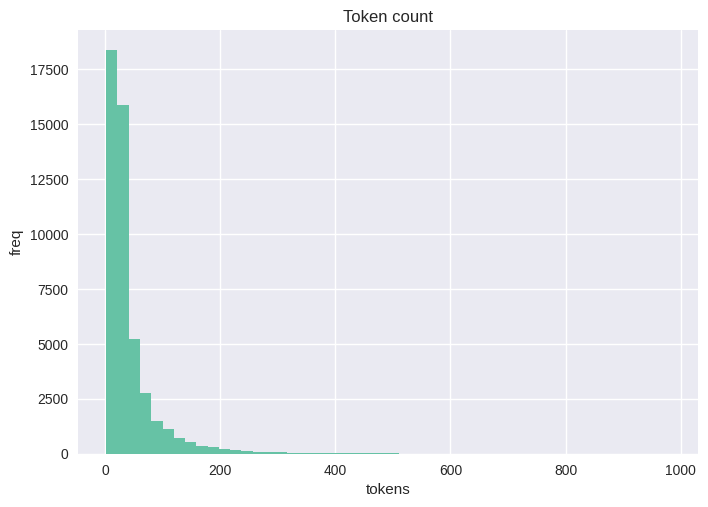

In [18]:
# Kiểm tra dữ liệu null và trùng lặp
print(raw_data.isna().sum().sort_values(ascending=False).head())
print("Duplicates:", raw_data.duplicated().sum())

# Xác định cột văn bản và cột nhãn
obj_cols = [c for c in raw_data.columns if raw_data[c].dtype=='object']
text_col = max(obj_cols, key=lambda c: raw_data[c].astype(str).str.len().mean())
label_col = [c for c in raw_data.columns if c != text_col][0]  # dataset có 2 cột

print("text_col:", text_col, "label_col:", label_col)

# Thống kê phân phối nhãn
vc = raw_data[label_col].value_counts()
display(vc.head()); (vc/vc.sum()).head()

# Thống kê độ dài văn bản
lens = raw_data[text_col].astype(str).str.split().map(len)
print(lens.describe())
plt.figure(); lens.hist(bins=50); plt.title('Token count'); plt.xlabel('tokens'); plt.ylabel('freq'); plt.show()

# Đề xuất max_len và vocab_limit
max_len = int(np.percentile(lens, 95))  # gợi ý
vocab_limit = 30000

**Nhận xét về dữ liệu**

*Tính sạch của dữ liệu*

- Không có giá trị bị thiếu (NaN).

- Không có dòng trùng lặp.

-> Dữ liệu gốc rất sạch, không cần xử lý thiếu/trùng.

*Cột dữ liệu*

- Document: cột chứa văn bản (mô tả sự cố IT).

- Topic_group: cột nhãn phân loại (loại sự cố).

*Phân phối nhãn*

- 5 nhóm chính:

- Hardware: 13,617 mẫu

- HR Support: 10,915 mẫu

- Access: 7,125 mẫu

- Miscellaneous: 7,060 mẫu

- Storage: 2,777 mẫu

-> Các nhãn hơi mất cân bằng: Hardware nhiều gấp gần 5 lần Storage.
Cần lưu ý khi huấn luyện mô hình (có thể dùng class weights).

*Độ dài văn bản*

- Trung bình: ~44 từ.

- Median (50% dữ liệu): 26 từ.

- 75% dữ liệu: ≤ 46 từ.

- Văn bản dài nhất: 981 từ.

-> Biểu đồ histogram cho thấy đa số văn bản rất ngắn (<50 từ), chỉ một số ít cực dài → phân phối lệch phải (skewed).

*Tham số tiền xử lý đề xuất*

- max_len = ~120 (percentile 95) -> đủ bao phủ 95% dữ liệu, tránh bị outlier kéo dài.

- vocab_limit = 30,000 -> giới hạn từ vựng cho tokenizer, cân bằng giữa hiệu quả và tài nguyên.

In [19]:
#Chia train 80%, test 10%, validation 10%
from sklearn.model_selection import train_test_split
train, test = train_test_split(raw_data, test_size=0.1, stratify=raw_data[label_col], random_state=42)
train, val  = train_test_split(train,    test_size=0.1, stratify=train[label_col],    random_state=42)

In [20]:
#Import thư viện
!pip -q install emoji unidecode
import nltk; nltk.download('stopwords')
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as sk_sw
from nltk.corpus import stopwords
from emoji import replace_emoji
from unidecode import unidecode
import unicodedata
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
std_english_stop = set(stopwords.words('english')) | set(sk_sw)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
# # ===========================================
# # Domain Stopwords Mining (1 function, 3 steps) — FIXED
# # ===========================================
# def extract_domain_stopwords(
#     corpus, y,
#     *,
#     ngram_range=(1,2),
#     min_df=2,
#     df_ratio_thres=0.05,          # nới: 5% văn bản
#     p_thres=0.20,
#     mi_thres=None,                # bỏ MI nếu muốn nhanh
#     confirm_with_lr=False,
#     cv_splits=5,
#     weak_coef_frac=0.05,
#     max_features=None,
#     max_df=None,
#     lowercase=False,
#     verbose=True,
#     use_binary=True,              # NEW: dùng ma trận nhị phân cho χ²/MI
#     combine_rule="or",            # NEW: 'and' hoặc 'or'
#     df_topk=None                  # NEW: thêm cơ chế top-K theo DF (vd 300)
# ):
#     vec = CountVectorizer(ngram_range=ngram_range, min_df=min_df,
#                           max_df=max_df, max_features=max_features,
#                           lowercase=lowercase, stop_words=None)
#     X = vec.fit_transform(corpus)
#     vocab = vec.get_feature_names_out()
#     n_docs = X.shape[0]

#     # DF & candidates theo tỉ lệ
#     df = (X > 0).sum(axis=0).A1
#     df_ratio = df / float(n_docs)
#     cand_mask = df_ratio >= df_ratio_thres
#     cand_high_df = [t for t in vocab[cand_mask] if (len(t) >= 2 and not t.isdigit())]

#     # (tuỳ chọn) thêm top-K theo DF
#     if df_topk:
#         top_idx = df.argsort()[::-1][:df_topk]
#         top_df_tokens = set(vocab[top_idx])
#     else:
#         top_df_tokens = set()

#     # Dùng nhị phân cho χ²/MI để tránh thiên lệch do lặp nhiều lần
#     X_stat = (X > 0).astype(int) if use_binary else X

#     chi2_val, chi2_p = chi2(X_stat, y)
#     if mi_thres is None:
#         mi_val = np.zeros(X.shape[1], dtype=float)
#         non_disc_mask = (chi2_p >= p_thres)
#     else:
#         mi_val = mutual_info_classif(X_stat, y, discrete_features=True, random_state=42)
#         if combine_rule == "and":
#             non_disc_mask = (chi2_p >= p_thres) & (mi_val <= mi_thres)
#         else:  # 'or'
#             non_disc_mask = (chi2_p >= p_thres) | (mi_val <= mi_thres)

#     non_discriminative = set(vocab[non_disc_mask])

#     # Giao các nguồn ứng viên
#     domain_stop_auto = (set(cand_high_df) | top_df_tokens) & non_discriminative

#     # (tuỳ chọn) Bước LR — khuyên tắt nếu chỉ cần nhanh
#     weak_by_coef = set()
#     if confirm_with_lr:
#         skf = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=42)
#         coef_abs_sum = np.zeros(X.shape[1], dtype=float)
#         clf = LogisticRegression(max_iter=200)
#         for tr, va in skf.split(X_stat, y):
#             clf.fit(X_stat[tr], y[tr])
#             coef_abs_sum += np.abs(clf.coef_).mean(axis=0)
#         coef_abs_mean = coef_abs_sum / cv_splits
#         k = max(1, int(weak_coef_frac * len(coef_abs_mean)))
#         weakest_idx = np.argsort(coef_abs_mean)[:k]
#         # giữ những từ không quá hiếm (vd DF ≥ 2% văn bản)
#         weak_by_coef = {vocab[i] for i in weakest_idx if (df[i]/n_docs) >= 0.02}

#     stopwords_final = domain_stop_auto | weak_by_coef

#     if verbose:
#         print(f"[INFO] vocab={len(vocab):,}, X={X.shape}, nnz={X.nnz:,}")
#         print(f"[INFO] DF≥{df_ratio_thres:.2f}: {sum(cand_mask):,} candidates"
#               + (f" | topK={df_topk}" if df_topk else ""))
#         print(f"[INFO] Non-disc ({combine_rule.upper()}): {non_disc_mask.sum():,}")
#         print(f"[INFO] Intersection (auto stopwords) = {len(domain_stop_auto):,}")
#         print(f"[INFO] ==> Proposed domain stopwords: {len(stopwords_final):,}")
#         print("[SAMPLE]:", sorted(list(stopwords_final))[:30])

#     return {
#         "stopwords": stopwords_final,
#         "vocab": vocab,
#         "df_ratio": df_ratio,
#         "chi2_p": chi2_p,
#         "mi_val": None if mi_thres is None else mi_val
#     }

# import numpy as np
# from typing import List, Tuple, Set
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.feature_selection import chi2, mutual_info_classif
# from sklearn.linear_model import LogisticRegression

# def mine_stopwords_freq_then_filter(
#     corpus: List[str],          # train texts (đã clean sơ bộ)
#     y: np.ndarray,              # train labels
#     *,
#     ngram_range: Tuple[int,int]=(1,2),
#     min_df: int|float=2,        # bỏ token quá hiếm khi vectorize
#     topk_df: int=500,           # lấy top-K token có DF cao nhất
#     metric: str="chi2",         # "chi2" | "mi" | "coef"
#     p_thres: float=0.20,        # ngưỡng p cho chi2 (p lớn ⇒ kém phân biệt)
#     mi_thres: float=1e-4,       # ngưỡng MI (nhỏ ⇒ kém phân biệt)
#     coef_frac: float=0.15,      # lấy bottom 5% |coef| nếu dùng "coef"
#     lowercase: bool=False,
# ) -> Set[str]:
#     # 1) Vectorize để có DF
#     vec = CountVectorizer(ngram_range=ngram_range, min_df=min_df,
#                           lowercase=lowercase, stop_words=None)
#     X = vec.fit_transform(corpus)
#     vocab = vec.get_feature_names_out()
#     n_docs = X.shape[0]
#     df = (X > 0).sum(axis=0).A1
#     top_idx = df.argsort()[::-1][:topk_df]
#     top_df_tokens = set(vocab[top_idx])

#     # 2) Đánh giá “kém phân biệt”
#     Xb = (X > 0).astype(int)  # dùng nhị phân để tránh thiên lệch do lặp
#     if metric == "chi2":
#         _, p = chi2(Xb, y)
#         non_disc = set(vocab[p >= p_thres])
#     elif metric == "mi":
#         mi = mutual_info_classif(Xb, y, discrete_features=True, random_state=42)
#         non_disc = set(vocab[mi <= mi_thres])
#     elif metric == "coef":
#         clf = LogisticRegression(max_iter=200)
#         clf.fit(Xb, y)
#         coef_abs = np.abs(clf.coef_).mean(axis=0)
#         k = max(1, int(coef_frac * len(coef_abs)))
#         weak_idx = np.argsort(coef_abs)[:k]
#         non_disc = set(vocab[weak_idx])

#     else:
#         raise ValueError("metric phải là 'chi2', 'mi' hoặc 'coef'.")

#     # 3) Giao 2 tập
#     print(len(non_disc))
#     return non_disc
import numpy as np
from typing import List, Tuple, Dict, Any, Set
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

def mine_stopwords_topPct_coef(
    corpus: List[str],           # TRAIN texts (đã clean sơ bộ, CHƯA remove stopwords)
    y: np.ndarray,               # TRAIN labels
    *,
    ngram_range: Tuple[int,int]=(1,2),
    min_df: int|float=2,         # bỏ token quá hiếm khi vectorize
    top_pct: float=0.10,         # lấy Top-X% DF làm candidate (vd 0.10 = 10%)
    lowercase: bool=False,
    use_binary: bool=True,       # dùng X>0 cho LR để tránh thiên lệch do lặp
    class_weight: str|dict="balanced",
    max_iter: int=300,
    # chọn “gần 0” theo 1 trong 2 cách:
    mode: str="frac",            # 'frac' | 'eps'
    bottom_frac: float=0.05,     # nếu mode='frac': lấy bottom 5% theo |coef|
    eps: float=1e-2,             # nếu mode='eps' : chọn |coef| <= eps
    verbose: bool=True
) -> Dict[str, Any]:
    """
    1) Chọn Top-X% token theo DF làm candidate.
    2) Train LogisticRegression(class_weight='balanced') trên tập candidate.
    3) Lọc các token có |coef| ≈ 0 => stopwords domain.

    Trả về: {'stopwords', 'vocab', 'candidates', 'coef_abs', 'top_idx', 'df'}
    """
    # ----- Vectorize toàn bộ (để tính DF) -----
    vec = CountVectorizer(ngram_range=ngram_range, min_df=min_df,
                          lowercase=lowercase, stop_words=None)
    X = vec.fit_transform(corpus)                      # sparse [n_samples, n_features]
    vocab = vec.get_feature_names_out()
    n_docs = X.shape[0]
    df = (X > 0).sum(axis=0).A1

    # ----- Top-X% theo DF làm candidates -----
    m = len(vocab)
    k = max(1, int(top_pct * m))
    order = df.argsort()[::-1]                        # desc DF
    top_idx = order[:k]
    cand_vocab = vocab[top_idx]

    # ----- Ma trận cho LR -----
    Xc = X[:, top_idx]
    if use_binary:
        Xc = (Xc > 0).astype(int)                     # binary presence

    # ----- Train LR (balanced) -----
    clf = LogisticRegression(
        class_weight=class_weight,
        max_iter=max_iter,
        n_jobs=None if hasattr(LogisticRegression(), "n_jobs") else None
    )
    clf.fit(Xc, y)

    # Lấy |coef| (n_classes x k) -> trung bình theo lớp
    coef_abs = np.abs(clf.coef_).mean(axis=0)         # shape (k,)

    # ----- Chọn “gần 0” -----
    if mode == "frac":
        bw = max(1, int(bottom_frac * len(coef_abs))) # bottom k%
        weak_local_idx = np.argsort(coef_abs)[:bw]
        stopwords_auto = set(cand_vocab[weak_local_idx])
    elif mode == "eps":
        weak_local_idx = np.where(coef_abs <= eps)[0]
        stopwords_auto = set(cand_vocab[weak_local_idx])
    else:
        raise ValueError("mode phải là 'frac' hoặc 'eps'.")

    if verbose:
        print(f"[INFO] vocab={m:,}, X={X.shape}, nnz={X.nnz:,}")
        print(f"[INFO] candidates (Top {int(top_pct*100)}% DF) = {len(cand_vocab):,}")
        if mode == "frac":
            print(f"[INFO] stopwords (|coef| bottom {int(bottom_frac*100)}%) = {len(stopwords_auto):,}")
        else:
            print(f"[INFO] stopwords (|coef| <= {eps}) = {len(stopwords_auto):,}")
        # Ví dụ vài từ “gần 0”
        ex = sorted(list(stopwords_auto))[:30]
        print("[SAMPLE]", ex)

    return {
        "stopwords": stopwords_auto,
        "vocab": vocab,
        "candidates": cand_vocab,
        "coef_abs": coef_abs,     # |coef| tương ứng với cand_vocab
        "top_idx": top_idx,
        "df": df
    }

In [22]:
import re

def normalize_stopset(stopset):
    out = set()
    for t in stopset:
        if not isinstance(t, str):
            continue
        t = t.strip().lower()
        if not t:
            continue
        # tách theo khoảng trắng, chỉ giữ token chữ/số (đã clean lowercase từ trước)
        parts = re.findall(r"\w+", t)
        out.update(parts)
    return out

In [23]:
# class TextPreprocessor:
#     def __init__(self, lower=True, strip_accents=False,
#                  remove_urls=True, remove_emojis=True,
#                  remove_special=True, remove_numbers=False,
#                  remove_stopwords=True, stopwords = None,
#                  max_words=30000, max_len=128, oov_token='<OOV>'):
#         # Thiết lập tham số tiền xử lý
#         self.lower=lower; self.strip_accents=strip_accents
#         self.remove_urls=remove_urls; self.remove_emojis=remove_emojis
#         self.remove_special=remove_special; self.remove_numbers=remove_numbers
#         self.stop=set(stopwords) if stopwords else set()
#         # Tokenizer để biến từ thành số
#         self.tok=Tokenizer(num_words=max_words, oov_token=oov_token)
#         self.max_len=max_len

#     def _clean(self, s):
#         # Làm sạch 1 câu văn bản
#         if not isinstance(s,str): s=str(s)
#         if self.lower: s=s.lower()
#         if self.strip_accents: s=unidecode(s)
#         if self.remove_urls: s=re.sub(r'(http\S+|www\.\S+|[\w\.-]+@[\w\.-]+|@\w+|#\w+)', ' ', s)
#         if self.remove_emojis: s=replace_emoji(s, replace='')
#         if self.remove_special: s=re2.sub(r"[^\p{L}\p{N}\s]", " ", s)
#         if self.remove_numbers: s=re.sub(r"\d+", " ", s)
#         toks=re.findall(r"\w+", s, flags=re.UNICODE)
#         if self.stop: toks=[t for t in toks if t not in self.stop]
#         return " ".join(toks)

#     def fit(self, texts):
#         # Làm sạch + xây dựng từ điển từ train
#         cleaned=[self._clean(t) for t in texts]
#         self.tok.fit_on_texts(cleaned)
#         return cleaned

#     def transform(self, texts):
#         # Làm sạch + chuyển văn bản thành số + padding
#         cleaned=[self._clean(t) for t in texts]
#         seq=self.tok.texts_to_sequences(cleaned)
#         pad=pad_sequences(seq, maxlen=self.max_len, padding='post', truncating='post')
#         return pad, cleaned

#     def fit_transform(self, texts):
#         # Kết hợp fit và transform cho tập train
#         cleaned=self.fit(texts)
#         seq=self.tok.texts_to_sequences(cleaned)
#         pad=pad_sequences(seq, maxlen=self.max_len, padding='post', truncating='post')
#         return pad, cleaned
class TextPreprocessor:
    def __init__(self, lower=True, strip_accents=False,
                 remove_urls=True, remove_emojis=True,
                 remove_special=True, remove_numbers=False,
                 remove_stopwords=True, stopwords=None,
                 max_words=30000, max_len=128, oov_token='<OOV>'):
        # Thiết lập tham số tiền xử lý
        self.lower = lower
        self.strip_accents = strip_accents
        self.remove_urls = remove_urls
        self.remove_emojis = remove_emojis
        self.remove_special = remove_special
        self.remove_numbers = remove_numbers
        self.remove_stopwords = remove_stopwords
        # stopwords: set các token đã chuẩn hóa lowercase
        self.stop = set(stopwords) if stopwords else set()

        # Tokenizer để biến từ thành số
        self.tok = Tokenizer(num_words=max_words, oov_token=oov_token)
        self.max_len = max_len

    def _clean(self, s):
        # Làm sạch 1 câu văn bản
        if not isinstance(s, str):
            # ép kiểu an toàn nếu lỡ là bytes/number
            try:
                s = s.decode('utf-8', errors='ignore')
            except Exception:
                s = str(s)

        # Chuẩn hóa Unicode + loại một số zero-width phổ biến
        s = unicodedata.normalize('NFKC', s)
        s = s.replace('\u2009', '').replace('\u200b', '')

        if self.lower:
            s = s.lower()
        if self.strip_accents:
            s = unidecode(s)

        # URL / email / mention / hashtag (thay bằng khoảng trắng để tránh dính chữ)
        if self.remove_urls:
            s = re.sub(r'(https?://\S+|www\.\S+|[\w\.-]+@[\w\.-]+\.\w+|@\w+|#\w+)', ' ', s)

        # Emoji → xóa (hoặc thay bằng khoảng trắng)
        if self.remove_emojis:
            s = replace_emoji(s, replace=' ')

        # Loại ký tự đặc biệt, giữ chữ cái (cả tiếng Việt), số và khoảng trắng
        if self.remove_special:
            s = re2.sub(r"[^\p{L}\p{N}\s]", " ", s)

        # Loại số nếu cần
        if self.remove_numbers:
            s = re.sub(r"\d+(\.\d+)?", " ", s)

        # Tokenize đơn giản theo \w+ (UNIDODE) rồi remove stopwords nếu bật
        toks = re.findall(r"\w+", s, flags=re.UNICODE)
        if self.remove_stopwords and self.stop:
            toks = [t for t in toks if t not in self.stop]

        # Ghép lại & chuẩn hóa khoảng trắng
        return " ".join(toks).strip()

    def fit(self, texts):
        # Làm sạch + xây dựng từ điển từ train
        cleaned = [self._clean(t) for t in texts]
        self.tok.fit_on_texts(cleaned)
        return cleaned

    def transform(self, texts):
        # Làm sạch + chuyển văn bản thành số + padding
        cleaned = [self._clean(t) for t in texts]
        seq = self.tok.texts_to_sequences(cleaned)
        pad = pad_sequences(seq, maxlen=self.max_len, padding='post', truncating='post')
        return pad, cleaned

    def fit_transform(self, texts):
        # Kết hợp fit và transform cho tập train
        cleaned = self.fit(texts)
        seq = self.tok.texts_to_sequences(cleaned)
        pad = pad_sequences(seq, maxlen=self.max_len, padding='post', truncating='post')
        return pad, cleaned

In [99]:
# Khởi tạo bộ tiền xử lý với tham số đã chọn
tp_basic = TextPreprocessor(
    lower=True,
    strip_accents=False,
    remove_urls=True,
    remove_emojis=True,
    remove_special=True,
    remove_numbers=False,     # giữ lại số (mã lỗi, version có thể quan trọng)
    remove_stopwords=False,
    stopwords=None,
    max_words=vocab_limit,    # giới hạn từ vựng
    max_len=max_len           # chiều dài chuỗi sau padding
)

# Tiền xử lý văn bản -> chuyển thành chuỗi số đã padding
_,tr_cleaned = tp_basic.fit_transform(train[text_col].astype(str))   # fit trên train
_,va_cleaned = tp_basic.transform(val[text_col].astype(str))         # transform val
_, te_cleaned = tp_basic.transform(test[text_col].astype(str))        # transform test

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
ytr = le.fit_transform(train[label_col])
yva = le.transform(val[label_col])
yte = le.transform(test[label_col])
res = mine_stopwords_topPct_coef(
    corpus=tr_cleaned, y=ytr,
    ngram_range=(1,2),
    min_df=2,
    top_pct=0.005,
    lowercase=False,
    use_binary=True,
    class_weight="balanced",
    max_iter=300,
    mode="frac",         # lấy bottom theo tỉ lệ
    bottom_frac=0.02,    # bottom 5% |coef|
    verbose=True
)

DOMAIN_STOP_AUTO = res["stopwords"]
FINAL_STOPWORDS = normalize_stopset(DOMAIN_STOP_AUTO) | std_english_stop

tp = TextPreprocessor(
    lower=True, strip_accents=False,
    remove_urls=True, remove_emojis=True,
    remove_special=True, remove_numbers=False,
    remove_stopwords=True,
    stopwords=FINAL_STOPWORDS
)
_, tr_clean = tp.fit_transform(train[text_col].astype(str))
_, va_clean = tp.transform(val[text_col].astype(str))
_, te_clean = tp.transform(test[text_col].astype(str))


[INFO] vocab=146,485, X=(38747, 146485), nnz=2,323,896
[INFO] candidates (Top 0% DF) = 732
[INFO] stopwords (|coef| bottom 2%) = 14
[SAMPLE] ['about', 'ask', 'dear', 'each subsidiaries', 'for', 'friday', 'march', 'new purchase', 'number whose', 'registered old', 'same', 'street kingdom', 'the', 'whose registered']


In [101]:
print("Số lượng stopwords domain:", len(DOMAIN_STOP_AUTO))
print("Số lượng stopwords domain:", len(FINAL_STOPWORDS))
print("Một vài stopwords:", list(sorted(FINAL_STOPWORDS))[:692])

Số lượng stopwords domain: 14
Số lượng stopwords domain: 409
Một vài stopwords: ['a', 'about', 'above', 'across', 'after', 'afterwards', 'again', 'against', 'ain', 'all', 'almost', 'alone', 'along', 'already', 'also', 'although', 'always', 'am', 'among', 'amongst', 'amoungst', 'amount', 'an', 'and', 'another', 'any', 'anyhow', 'anyone', 'anything', 'anyway', 'anywhere', 'are', 'aren', "aren't", 'around', 'as', 'ask', 'at', 'back', 'be', 'became', 'because', 'become', 'becomes', 'becoming', 'been', 'before', 'beforehand', 'behind', 'being', 'below', 'beside', 'besides', 'between', 'beyond', 'bill', 'both', 'bottom', 'but', 'by', 'call', 'can', 'cannot', 'cant', 'co', 'con', 'could', 'couldn', "couldn't", 'couldnt', 'cry', 'd', 'de', 'dear', 'describe', 'detail', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'done', 'down', 'due', 'during', 'each', 'eg', 'eight', 'either', 'eleven', 'else', 'elsewhere', 'empty', 'enough', 'etc', 'even', 'ever', 'ever

In [82]:
s = train[text_col].iloc[0]         # lấy 1 văn bản gốc từ tập train
_, c = tp.transform([s])            # tiền xử lý văn bản
print("RAW:", s)                    # in ra bản gốc
print("CLEAN:", c[0])               # in ra bản đã làm sạch

RAW: stage is catalogue item removed sent friday stage catalogue item removed hello could you please have look stage set catalog item removed cannot be changed could you please amend we resolve request kind regards specialist
CLEAN: stage catalogue item removed sent stage catalogue item removed hello look stage set catalog item removed changed amend resolve request kind regards specialist


In [111]:
import os, numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from scipy import sparse
from joblib import dump

# --------- (1) CẤU HÌNH / INPUT ----------
# Nếu notebook của bạn dùng tên khác, sửa 3 dòng dưới:
X_train_text = tr_clean
X_val_text   = va_clean
X_test_text  = te_clean

y_train = np.array(ytr)
y_val   = np.array(yva)
y_test  = np.array(yte)

# Tham số BoW — có thể tăng/giảm tùy dataset
MAX_FEATURES = 30000
NGRAMS       = (1, 2)   # dùng (1,2) nếu câu ngắn hoặc nhiều cụm từ đặc trưng
MIN_DF       = 2        # bỏ từ xuất hiện quá hiếm

# --------- Bag of Word ----------
bow_vectorizer = CountVectorizer(
    max_features=MAX_FEATURES,
    ngram_range=NGRAMS,
    min_df=MIN_DF,
    max_df= 0.9,
    lowercase=False, # text đã clean/lower từ trước
    stop_words = None,
    tokenizer=None,    # QUAN TRỌNG: không dùng tokenizer tùy biến ở đây
    preprocessor=None,# QUAN TRỌNG: không dùng preprocessor tùy biến ở đây
    analyzer="word"          # giữ mặc định word-level
)

Xtr_bow = bow_vectorizer.fit_transform(X_train_text)
Xva_bow = bow_vectorizer.transform(X_val_text)
Xte_bow = bow_vectorizer.transform(X_test_text)
vocab_bow = bow_vectorizer.get_feature_names_out()

# --------- TF - IDF ----------
tfidf = TfidfVectorizer(
    max_features=MAX_FEATURES,
    ngram_range=NGRAMS,
    min_df=MIN_DF,
    max_df= 0.9,
    lowercase=False, # text đã clean/lower từ trước
    stop_words = None,
    preprocessor=None,# QUAN TRỌNG: không dùng preprocessor tùy biến ở đây
    tokenizer=None,    # QUAN TRỌNG: không dùng tokenizer tùy biến ở đây
    use_idf=True,         # TF-IDF
    sublinear_tf=True,
    analyzer="word"          # giữ mặc định word-level
)
Xtr_tfidf = tfidf.fit_transform(X_train_text)
Xva_tfidf = tfidf.transform(X_val_text)
Xte_tfidf = tfidf.transform(X_test_text)
vocab_tfidf = tfidf.get_feature_names_out()
# # --------- (3) THỐNG KÊ NHANH ----------
# def sparsity_stats(X, name):
#     nnz = X.nnz
#     total = X.shape[0] * X.shape[1]
#     dens = nnz / total if total else 0.0
#     print(f"{name}: shape={X.shape}, nnz={nnz:,}, density={dens:.6f}")

# print("=== BoW summary ===")
# print("Vocab size (sau fit):", len(bow_vectorizer.vocabulary_))
# sparsity_stats(Xtr_bow, "Train")
# sparsity_stats(Xva_bow, "Val")
# sparsity_stats(Xte_bow, "Test")

In [112]:
import numpy as np
from collections import Counter

def summarize_bow(X, vocab, topn=20, name="Train"):
    """
    X: sparse matrix (n_samples, n_features) từ CountVectorizer/TfidfVectorizer
    vocab: list/ndarray các token tương ứng (vectorizer.get_feature_names_out())
    topn: số lượng token phổ biến muốn hiển thị
    name: tên tập (Train/Val/Test)
    """
    n_docs, n_vocab = X.shape
    nnz = X.nnz
    density = nnz / (n_docs * n_vocab)

    # số token trung bình/văn bản
    avg_tokens = nnz / n_docs

    # tính document frequency cho mỗi token
    df = (X > 0).sum(axis=0).A1
    top_idx = df.argsort()[::-1][:topn]

    print(f"=== {name} BoW summary ===")
    print(f"Shape = {X.shape}, nnz = {nnz:,}, density = {density:.6f}")
    print(f"Avg tokens per doc = {avg_tokens:.2f}")
    print(f"Top {topn} tokens by DF:")
    for i in top_idx:
        print(f"  {vocab[i]:20s} {df[i]} docs ({df[i]/n_docs:.1%})")



In [113]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# giả sử bạn đã có:
# Xtr_bow, ytr = train features, labels
# Xva_bow, yva = val features, labels
# Xte_bow, yte = test features, labels

clf1 = LogisticRegression(max_iter=1000, class_weight='balanced', n_jobs=-1)
clf2 = LogisticRegression(max_iter=1000, class_weight='balanced', n_jobs=-1)
# Huấn luyện trên train
clf1.fit(Xtr_bow, ytr)
clf2.fit(Xtr_tfidf, ytr)

# Dự đoán val/test
yva_pred_tfidf = clf2.predict(Xva_tfidf)
yte_pred_tfidf = clf2.predict(Xte_tfidf)
# Dự đoán val/test
yva_pred_bow = clf1.predict(Xva_bow)
yte_pred_bow = clf1.predict(Xte_bow)

# Đánh giá
print("=== Validation BoW ===")
print("Accuracy:", accuracy_score(yva, yva_pred_bow))
print(classification_report(yva, yva_pred_bow))

print("=== Test BoW===")
print("Accuracy:", accuracy_score(yte, yte_pred_bow))
print(classification_report(yte, yte_pred_bow))

print("=== Validation TF-IDF ===")
print("Accuracy:", accuracy_score(yva, yva_pred_tfidf))
print(classification_report(yva, yva_pred_tfidf))

print("=== Test TF-IDF ===")
print("Accuracy:", accuracy_score(yte, yte_pred_tfidf))
print(classification_report(yte, yte_pred_tfidf))


=== Validation BoW ===
Accuracy: 0.8485833720390153
              precision    recall  f1-score   support

           0       0.89      0.88      0.89       641
           1       0.77      0.77      0.77       158
           2       0.85      0.85      0.85       982
           3       0.85      0.82      0.84      1226
           4       0.83      0.87      0.85       191
           5       0.79      0.84      0.82       636
           6       0.93      0.91      0.92       222
           7       0.86      0.89      0.88       250

    accuracy                           0.85      4306
   macro avg       0.85      0.85      0.85      4306
weighted avg       0.85      0.85      0.85      4306

=== Test BoW===
Accuracy: 0.8605769230769231
              precision    recall  f1-score   support

           0       0.91      0.92      0.91       712
           1       0.79      0.84      0.82       176
           2       0.86      0.86      0.86      1092
           3       0.86      0.83  

In [104]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(Xtr_bow, ytr)

print("Val acc:", nb.score(Xva_bow, yva))
print(classification_report(yva, nb.predict(Xva_bow)))
print("Test acc:", nb.score(Xte_bow, yte))
print(classification_report(yte, nb.predict(Xte_bow)))

Val acc: 0.7875058058522991
              precision    recall  f1-score   support

           0       0.78      0.85      0.81       641
           1       0.68      0.59      0.64       158
           2       0.89      0.70      0.78       982
           3       0.80      0.81      0.81      1226
           4       0.64      0.83      0.72       191
           5       0.73      0.79      0.76       636
           6       0.94      0.88      0.91       222
           7       0.68      0.88      0.77       250

    accuracy                           0.79      4306
   macro avg       0.77      0.79      0.77      4306
weighted avg       0.80      0.79      0.79      4306

Test acc: 0.7903428093645485
              precision    recall  f1-score   support

           0       0.76      0.87      0.81       712
           1       0.70      0.70      0.70       176
           2       0.90      0.70      0.79      1092
           3       0.80      0.79      0.80      1362
           4       0.